<a href="https://colab.research.google.com/github/n1lays1ngh/Delhi-Air-Quality-Prediction/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense,GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import Huber

In [5]:
data_folder_path = '/content/drive/MyDrive/Pollutant Data'
input_file = os.path.join(data_folder_path, 'Final_Dataset.csv')

In [6]:

df = pd.read_csv(input_file, parse_dates=['Date'])

In [8]:
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.head()

,Date,index,AQI,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,AQI_lag_1,...,humidity_is_missing,precip_is_missing,windspeed_is_missing,sealevelpressure_is_missing,cond_unknown,cond_clear,cond_partially_cloudy,cond_rain_partially_cloudy,cond_rain,cond_rain_overcast
0,2017-01-08,7,288.0,0.5,0.866025,-0.781831,0.623490,0.137185,0.990545,278.0,...,1,1,1,1,1,0,0,0,0,0
1,2017-01-09,8,308.0,0.5,0.866025,0.000000,1.000000,0.154204,0.988039,288.0,...,1,1,1,1,1,0,0,0,0,0
2,2017-01-10,9,247.0,0.5,0.866025,0.781831,0.623490,0.171177,0.985240,308.0,...,1,1,1,1,1,0,0,0,0,0
3,2017-01-11,10,280.0,0.5,0.866025,0.974928,-0.222521,0.188099,0.982150,247.0,...,1,1,1,1,1,0,0,0,0,0
4,2017-01-12,11,323.0,0.5,0.866025,0.433884,-0.900969,0.204966,0.978769,280.0,...,1,1,1,1,1,0,0,0,0,0


In [11]:
dates = df['Date']
target_col = 'AQI'
features = df.drop(columns=['Date', 'index', target_col])
target = df[[target_col]]

In [12]:
features.head()

,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,AQI_lag_1,AQI_lag_3,AQI_lag_7,AQI_roll_mean_7,...,humidity_is_missing,precip_is_missing,windspeed_is_missing,sealevelpressure_is_missing,cond_unknown,cond_clear,cond_partially_cloudy,cond_rain_partially_cloudy,cond_rain,cond_rain_overcast
0,0.5,0.866025,-0.781831,0.623490,0.137185,0.990545,278.0,321.0,345.0,326.714286,...,1,1,1,1,1,0,0,0,0,0
1,0.5,0.866025,0.000000,1.000000,0.154204,0.988039,288.0,351.0,337.0,322.571429,...,1,1,1,1,1,0,0,0,0,0
2,0.5,0.866025,0.781831,0.623490,0.171177,0.985240,308.0,278.0,331.0,310.571429,...,1,1,1,1,1,0,0,0,0,0
3,0.5,0.866025,0.974928,-0.222521,0.188099,0.982150,247.0,288.0,381.0,296.142857,...,1,1,1,1,1,0,0,0,0,0
4,0.5,0.866025,0.433884,-0.900969,0.204966,0.978769,280.0,308.0,321.0,296.428571,...,1,1,1,1,1,0,0,0,0,0


In [13]:
target.head()

,AQI
0,288.0
1,308.0
2,247.0
3,280.0
4,323.0


In [14]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()


##Splitting the Data in 70:15:15 ratio for train , validate and test

In [15]:
n = len(df)
train_pct = 0.70
val_pct = 0.15

In [16]:
train_idx = int(n * train_pct)
val_idx = train_idx + int(n * val_pct)

X_train = features.iloc[:train_idx]
X_val = features.iloc[train_idx:val_idx]
X_test = features.iloc[val_idx:]

y_train = target.iloc[:train_idx]
y_val = target.iloc[train_idx:val_idx]
y_test = target.iloc[val_idx:]

In [17]:
X_train.head()

,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,AQI_lag_1,AQI_lag_3,AQI_lag_7,AQI_roll_mean_7,...,humidity_is_missing,precip_is_missing,windspeed_is_missing,sealevelpressure_is_missing,cond_unknown,cond_clear,cond_partially_cloudy,cond_rain_partially_cloudy,cond_rain,cond_rain_overcast
0,0.5,0.866025,-0.781831,0.623490,0.137185,0.990545,278.0,321.0,345.0,326.714286,...,1,1,1,1,1,0,0,0,0,0
1,0.5,0.866025,0.000000,1.000000,0.154204,0.988039,288.0,351.0,337.0,322.571429,...,1,1,1,1,1,0,0,0,0,0
2,0.5,0.866025,0.781831,0.623490,0.171177,0.985240,308.0,278.0,331.0,310.571429,...,1,1,1,1,1,0,0,0,0,0
3,0.5,0.866025,0.974928,-0.222521,0.188099,0.982150,247.0,288.0,381.0,296.142857,...,1,1,1,1,1,0,0,0,0,0
4,0.5,0.866025,0.433884,-0.900969,0.204966,0.978769,280.0,308.0,321.0,296.428571,...,1,1,1,1,1,0,0,0,0,0


In [18]:
X_val.head()

,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,AQI_lag_1,AQI_lag_3,AQI_lag_7,AQI_roll_mean_7,...,humidity_is_missing,precip_is_missing,windspeed_is_missing,sealevelpressure_is_missing,cond_unknown,cond_clear,cond_partially_cloudy,cond_rain_partially_cloudy,cond_rain,cond_rain_overcast
2103,-0.866025,0.5,0.974928,-0.222521,-0.981947,0.189155,66.0,48.0,211.0,70.142857,...,0,0,0,0,0,0,1,0,0,0
2104,-0.866025,0.5,0.433884,-0.900969,-0.978548,0.206018,143.0,44.0,79.0,77.428571,...,0,0,0,0,0,1,0,0,0,0
2105,-0.866025,0.5,-0.433884,-0.900969,-0.974860,0.222820,130.0,66.0,55.0,91.571429,...,0,0,0,0,0,1,0,0,0,0
2106,-0.866025,0.5,-0.974928,-0.222521,-0.970882,0.239557,154.0,143.0,56.0,110.142857,...,0,0,0,0,0,1,0,0,0,0
2107,-0.866025,0.5,-0.781831,0.623490,-0.966618,0.256222,186.0,130.0,48.0,136.428571,...,0,0,0,0,0,1,0,0,0,0


In [20]:
y_train.head()

,AQI
0,288.0
1,308.0
2,247.0
3,280.0
4,323.0


In [21]:
scaler_features.fit(X_train)
scaler_target.fit(y_train)

X_train_scaled = scaler_features.transform(X_train)
X_val_scaled = scaler_features.transform(X_val)
X_test_scaled = scaler_features.transform(X_test)

y_train_scaled = scaler_target.transform(y_train)
y_val_scaled = scaler_target.transform(y_val)
y_test_scaled = scaler_target.transform(y_test)

In [22]:
n_steps = 7
batch_size = 32
n_features = X_train_scaled.shape[1]

train_generator = TimeseriesGenerator(
    X_train_scaled, y_train_scaled,
    length=n_steps, batch_size=batch_size
)

validation_generator = TimeseriesGenerator(
    X_val_scaled, y_val_scaled,
    length=n_steps, batch_size=batch_size
)

test_generator = TimeseriesGenerator(
    X_test_scaled, y_test_scaled,
    length=n_steps, batch_size=1, shuffle=False
)


## Building the Model


In [23]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        17,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,251 (67.39 KB)

 Trainable params: 17,251 (67.39 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [24]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1237 - val_loss: 0.0169
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - val_loss: 0.0172
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265 - val_loss: 0.0175
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.0144
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0134
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0147
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0128
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - val_loss: 0.0117
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - val_loss: 0.0118
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0118
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0118
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0120

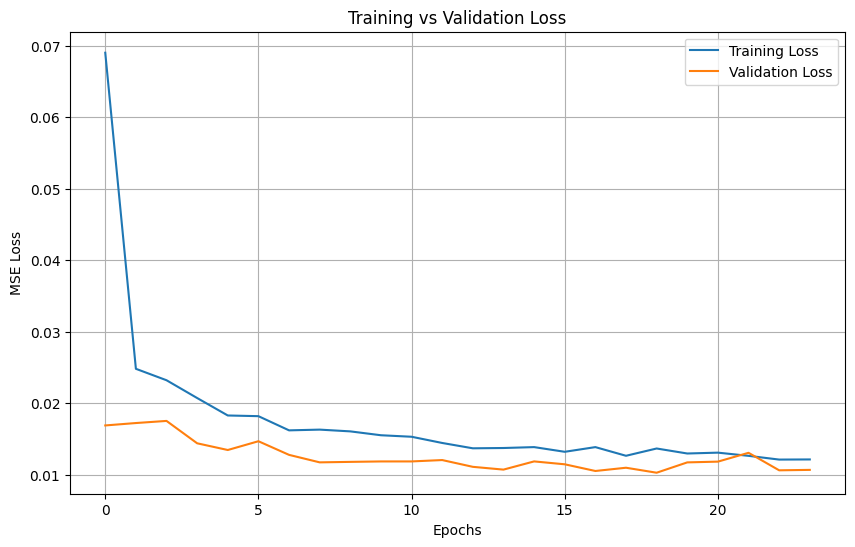

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
pred_scaled = model.predict(test_generator)

true_scaled = y_test_scaled[n_steps:]
true_real = scaler_target.inverse_transform(true_scaled)
pred_real = scaler_target.inverse_transform(pred_scaled)

rmse = np.sqrt(mean_squared_error(true_real, pred_real))
r2 = 1 - np.sum((true_real - pred_real)**2) / np.sum((true_real - np.mean(true_real))**2)
print(f"RMSE on Test Set: {rmse:.2f} AQI points")
print(f"R² Score: {r2:.4f}")


445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE on Test Set: 45.42 AQI points
R² Score: 0.7920


In [29]:
dates_test = dates.iloc[val_idx + n_steps:]

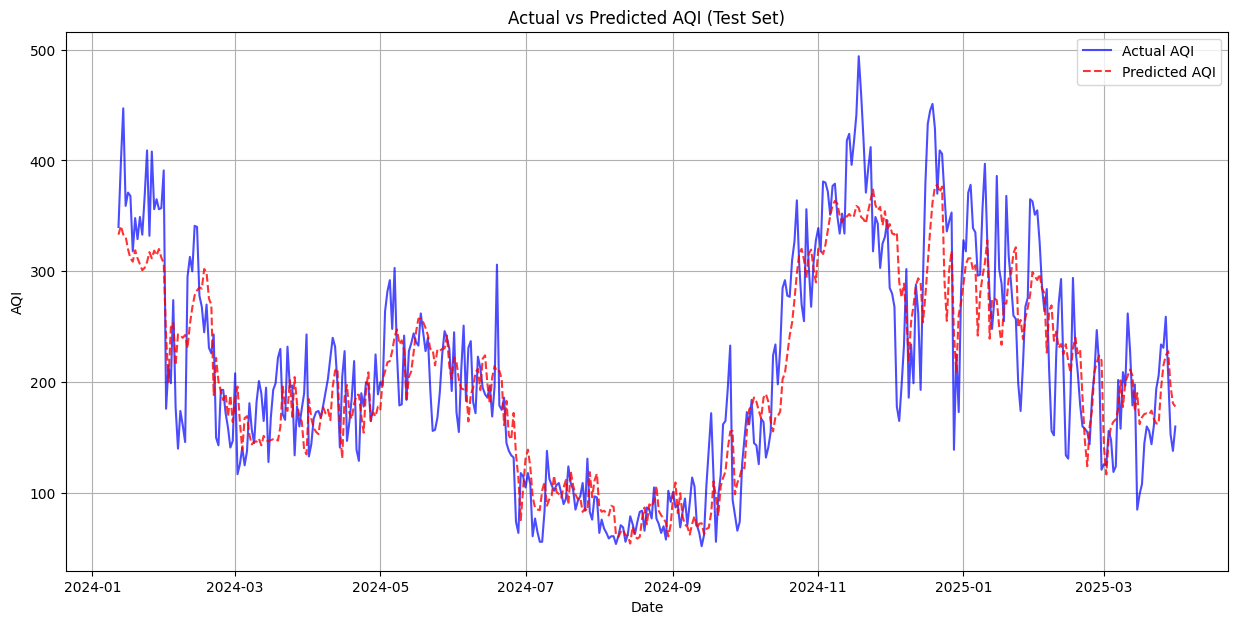

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(dates_test, true_real, label="Actual AQI", color="blue", alpha=0.7)
plt.plot(dates_test, pred_real, label="Predicted AQI", color="red", linestyle="--", alpha=0.8)
plt.title("Actual vs Predicted AQI (Test Set)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

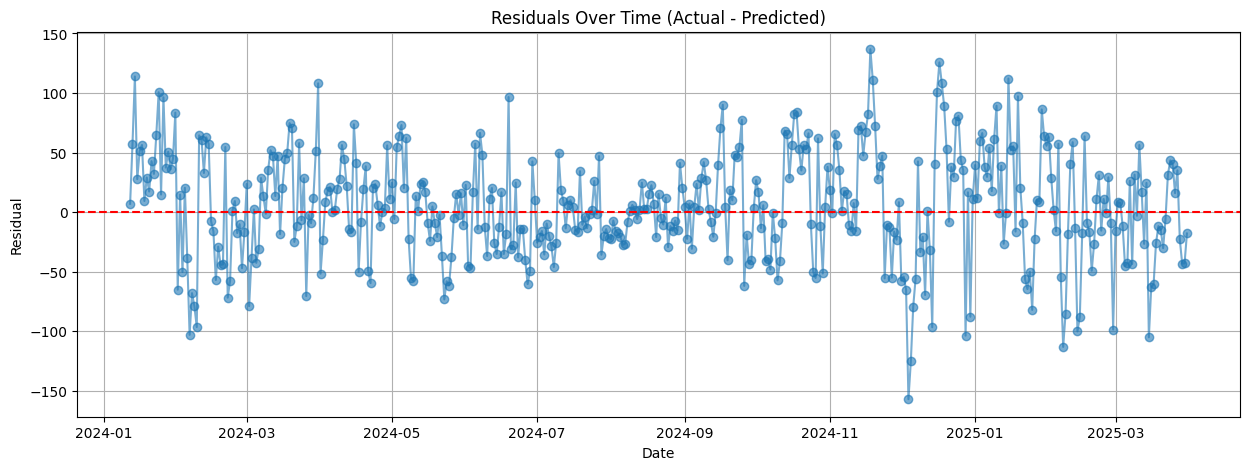

In [31]:
residuals = true_real - pred_real

plt.figure(figsize=(15, 5))
plt.plot(dates_test, residuals, marker='o', linestyle='-', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

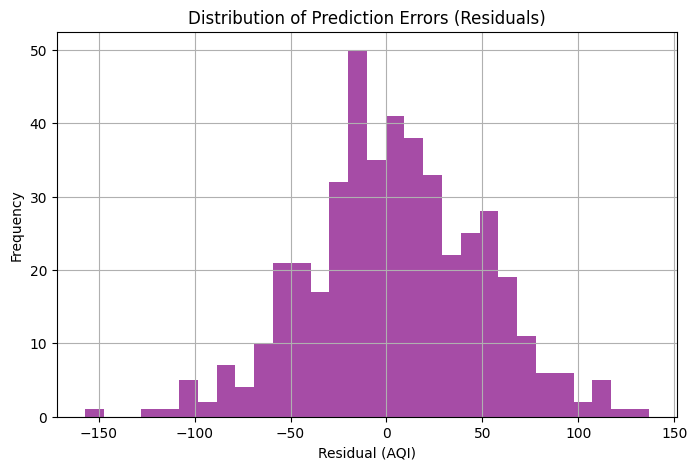

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residual (AQI)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Training a Deeper LSTM Model to make the model better

In [35]:
model_stacked = Sequential()
model_stacked.add(LSTM(64, return_sequences=True, activation='relu',
                       input_shape=(n_steps, n_features)))
model_stacked.add(Dropout(0.2))

model_stacked.add(LSTM(32, return_sequences=False, activation='relu'))
model_stacked.add(Dropout(0.2))

model_stacked.add(Dense(16, activation='relu'))
model_stacked.add(Dense(1, activation='linear'))

model_stacked.compile(optimizer='adam', loss='mse')
model_stacked.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 7, 64)          │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,561 (150.63 KB)

 Trainable params: 38,561 (150.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_stacked = model_stacked.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0586 - val_loss: 0.0159
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - val_loss: 0.0195
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 - val_loss: 0.0172
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216 - val_loss: 0.0163
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0171
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0138
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0149
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0137
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0124
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_

In [41]:
def evaluate_model(model, name):
    print(f"\n===== Evaluating: {name} =====")
    preds_scaled = model.predict(test_generator)
    true_scaled = y_test_scaled[n_steps:]

    pred_real = scaler_target.inverse_transform(preds_scaled).flatten()
    true_real = scaler_target.inverse_transform(true_scaled).flatten()

    rmse = np.sqrt(mean_squared_error(true_real, pred_real))
    r2 = 1 - np.sum((true_real - pred_real)**2) / np.sum((true_real - np.mean(true_real))**2)
    print(f"RMSE on Test Set: {rmse:.2f} AQI points")
    print(f"R² Score: {r2:.4f}")

    return rmse,pred_real,true_real

rmse_stacked , pred_real_stacked , true_real_stacked = evaluate_model(model_stacked, "Stacked LSTM")





===== Evaluating: Stacked LSTM =====
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE on Test Set: 45.22 AQI points
R² Score: 0.7938


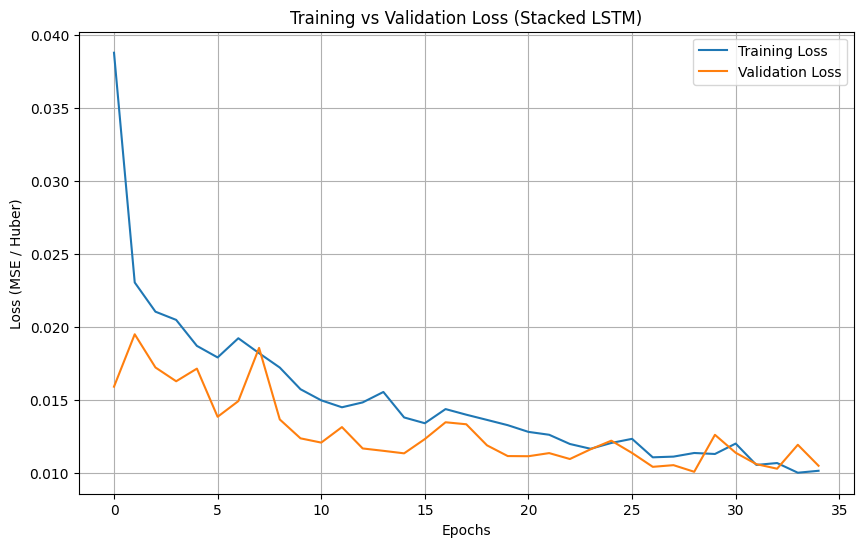

In [78]:
plot_loss(history_stacked, "Training vs Validation Loss (Stacked LSTM)")

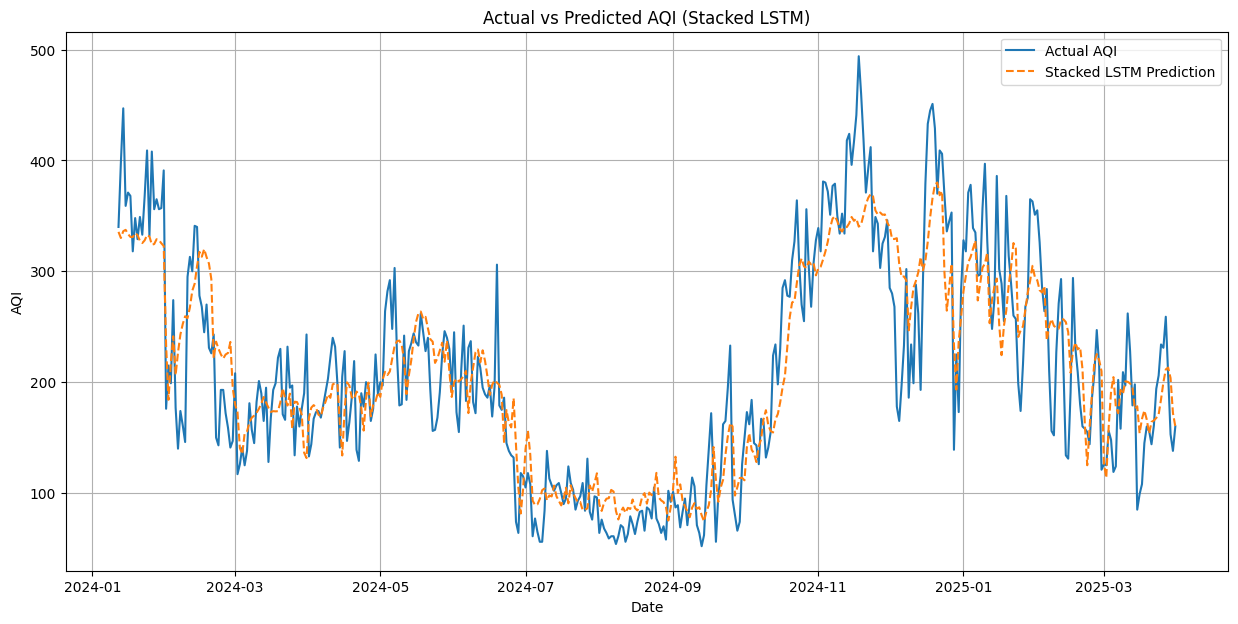

In [44]:
# Plot Actual vs Predicted
plt.figure(figsize=(15,7))
plt.plot(dates_test, true_real_stacked, label="Actual AQI")
plt.plot(dates_test, pred_real_stacked, label=f"Stacked LSTM Prediction", linestyle='--')
plt.title(f"Actual vs Predicted AQI (Stacked LSTM)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

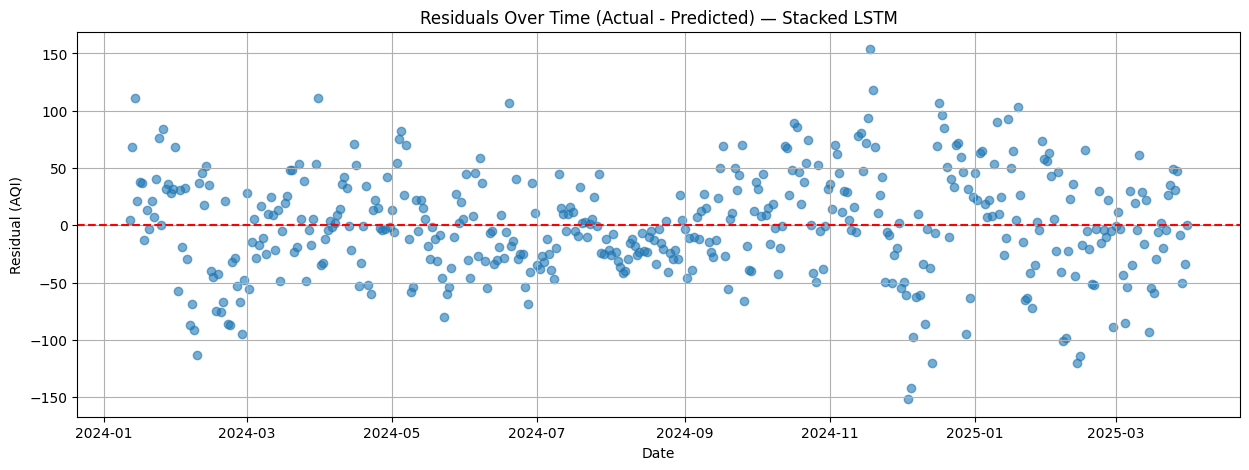

In [45]:
residuals = true_real_stacked - pred_real_stacked

plt.figure(figsize=(15, 5))
plt.scatter(dates_test, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time (Actual - Predicted) — Stacked LSTM")
plt.xlabel("Date")
plt.ylabel("Residual (AQI)")
plt.grid(True)
plt.show()


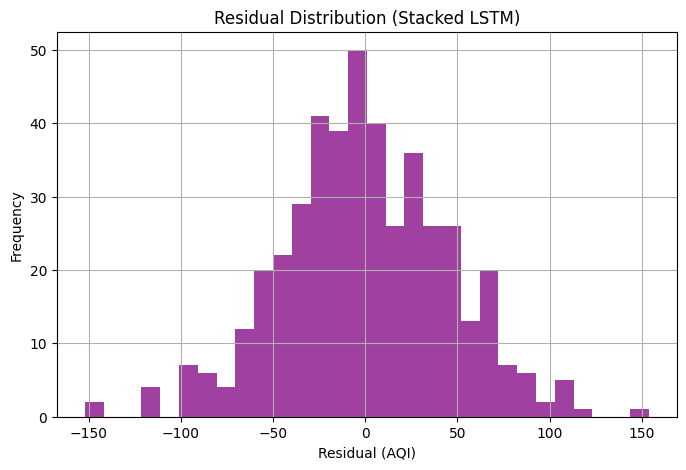

In [46]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color="purple", alpha=0.75)
plt.title("Residual Distribution (Stacked LSTM)")
plt.xlabel("Residual (AQI)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [48]:
model_cnn_lstm = Sequential()


model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                          input_shape=(n_steps, n_features)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))


model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dropout(0.3))


model_cnn_lstm.add(Dense(32, activation='relu'))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,449 (122.85 KB)

 Trainable params: 31,449 (122.85 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_cnn_lstm = model_cnn_lstm.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0728 - val_loss: 0.0218
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0165
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - val_loss: 0.0218
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0154
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0154
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0157
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0188
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0154
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0168
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - val_loss: 0.0192
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - val_l

In [50]:
rmse_CNN_LSTM , pred_real_CNN_LSTM,true_real_CNN_LSTM = evaluate_model(model_cnn_lstm, "CNN+LSTM")


===== Evaluating: CNN+LSTM =====
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
RMSE on Test Set: 54.45 AQI points
R² Score: 0.7012


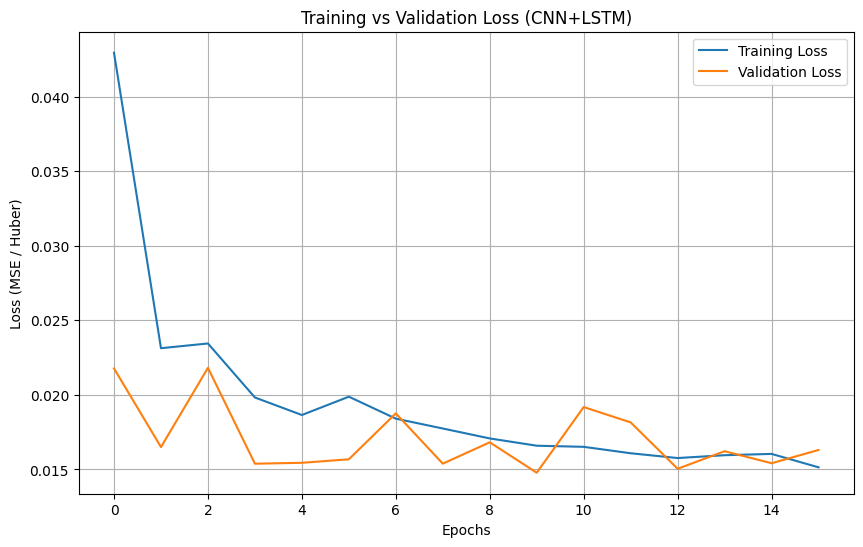

In [77]:
plot_loss(history_cnn_lstm, "Training vs Validation Loss (CNN+LSTM)")

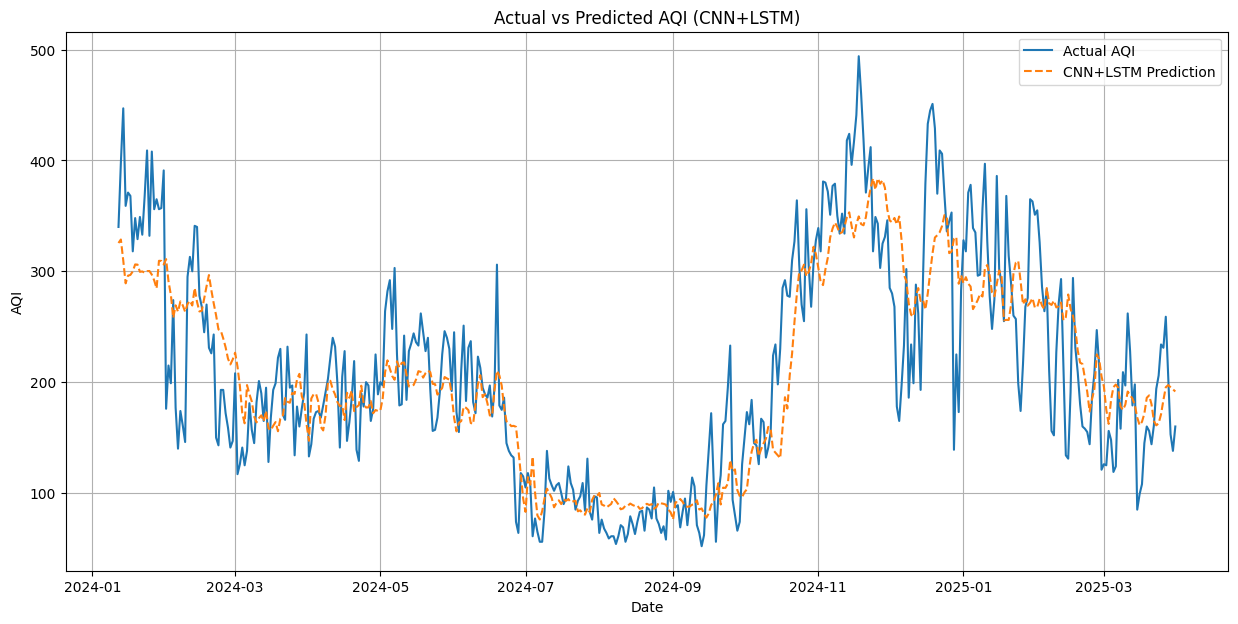

In [54]:
plt.figure(figsize=(15,7))
plt.plot(dates_test, true_real_CNN_LSTM, label="Actual AQI")
plt.plot(dates_test, pred_real_CNN_LSTM, label=f"CNN+LSTM Prediction", linestyle='--')
plt.title(f"Actual vs Predicted AQI (CNN+LSTM)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

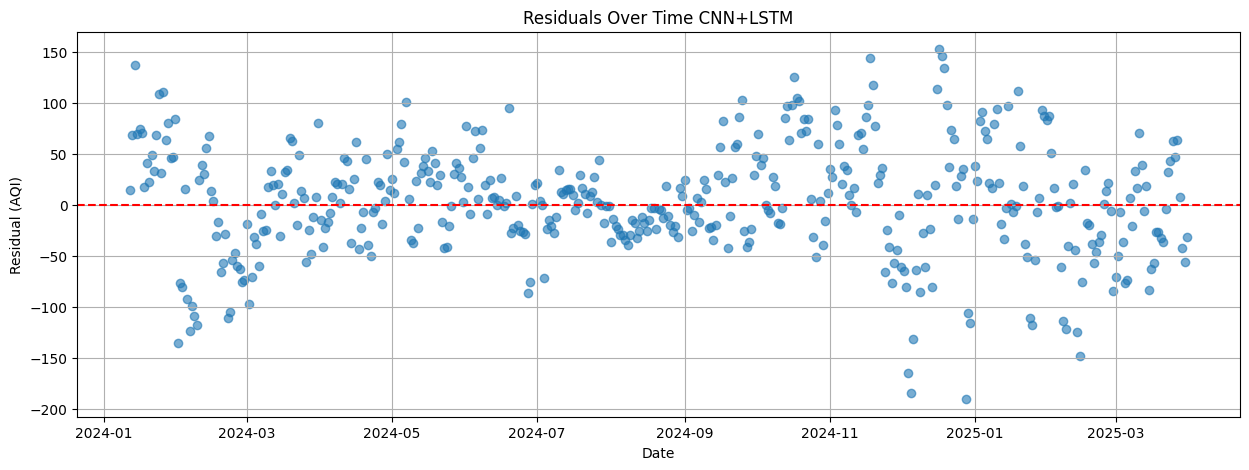

In [75]:
residuals = true_real_CNN_LSTM - pred_real_CNN_LSTM

plt.figure(figsize=(15, 5))
plt.scatter(dates_test, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time CNN+LSTM")
plt.xlabel("Date")
plt.ylabel("Residual (AQI)")
plt.grid(True)
plt.show()


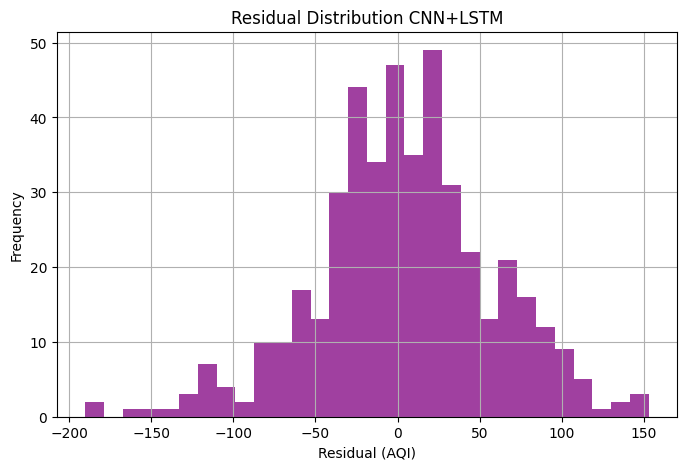

In [76]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color="purple", alpha=0.75)
plt.title("Residual Distribution CNN+LSTM")
plt.xlabel("Residual (AQI)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Using n_steps = 15 to check whether the model can do better with longer data packaging

In [55]:
n_steps_15 = 15
batch_size = 32
n_features = X_train_scaled.shape[1]

train_gen_15 = TimeseriesGenerator(
    X_train_scaled, y_train_scaled,
    length=n_steps_15,
    batch_size=batch_size
)

val_gen_15 = TimeseriesGenerator(
    X_val_scaled, y_val_scaled,
    length=n_steps_15,
    batch_size=batch_size
)

test_gen_15 = TimeseriesGenerator(
    X_test_scaled, y_test_scaled,
    length=n_steps_15,
    batch_size=1,
    shuffle=False
)

In [56]:

model_stacked_15 = Sequential()
model_stacked_15.add(LSTM(
    64, return_sequences=True, activation='tanh',
    input_shape=(n_steps_15, n_features)
))
model_stacked_15.add(Dropout(0.25))

model_stacked_15.add(LSTM(32, activation='tanh'))
model_stacked_15.add(Dropout(0.2))

model_stacked_15.add(Dense(16, activation='relu'))
model_stacked_15.add(Dense(1, activation='linear'))

model_stacked_15.compile(optimizer='adam', loss='mse')
model_stacked_15.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

history_15 = model_stacked_15.fit(
    train_gen_15,
    validation_data=val_gen_15,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 15, 64)         │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,561 (150.63 KB)

 Trainable params: 38,561 (150.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0945 - val_loss: 0.0217
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0235 - val_loss: 0.0177
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0222 - val_loss: 0.0162
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0209 - val_loss: 0.0226
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0229 - val_loss: 0.0175
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0178 - val_loss: 0.0165
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0198 - val_loss: 0.0154
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149 - val_loss: 0.0

In [57]:
rmse_15 , pred_15 , true_15 = evaluate_model(model_stacked_15, "Stacked LSTM 15")


===== Evaluating: Stacked LSTM 15 =====
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
RMSE on Test Set: 54.71 AQI points
R² Score: 0.6983


In [58]:
n_steps_gru = 7
batch_size = 32
epochs = 50
tf.random.set_seed(42)


train_gen_gru = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_steps_gru, batch_size=batch_size)
val_gen_gru   = TimeseriesGenerator(X_val_scaled, y_val_scaled, length=n_steps_gru, batch_size=batch_size)
test_gen_gru  = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_steps_gru, batch_size=1, shuffle=False)


In [61]:
model_gru = Sequential([
    GRU(128, return_sequences=True, activation='tanh', input_shape=(n_steps_gru, n_features)),
    Dropout(0.25),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train
history_gru = model_gru.fit(
    train_gen_gru,
    validation_data=val_gen_gru,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 128)         │        63,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,721 (401.25 KB)

 Trainable params: 102,721 (401.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0388 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0259 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━

In [62]:
rmse_GRU , pred_GRU , true_GRU = evaluate_model(model_gru, "GRU")


===== Evaluating: GRU =====
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE on Test Set: 38.45 AQI points
R² Score: 0.8510


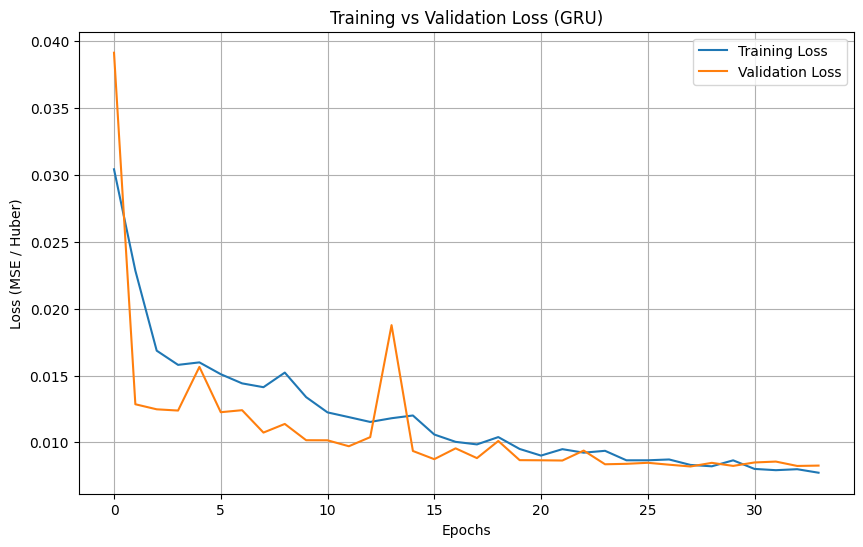

In [72]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE / Huber)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_gru, "Training vs Validation Loss (GRU)")

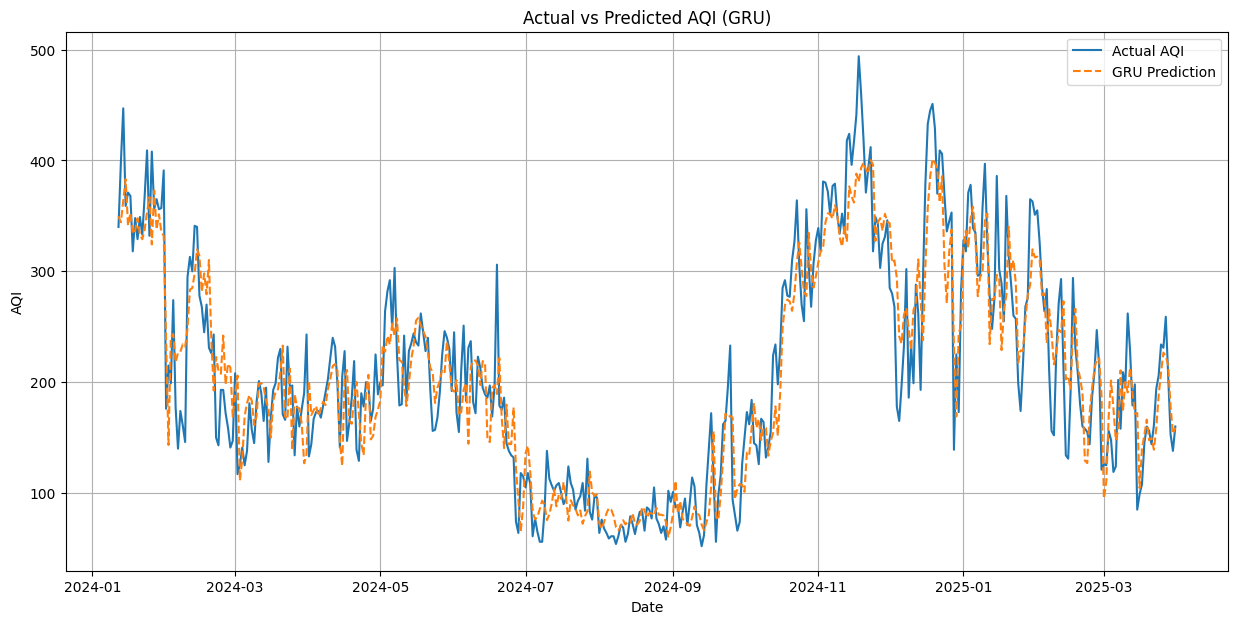

In [64]:
plt.figure(figsize=(15,7))
plt.plot(dates_test, true_GRU, label="Actual AQI")
plt.plot(dates_test, pred_GRU, label=f"GRU Prediction", linestyle='--')
plt.title(f"Actual vs Predicted AQI (GRU)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

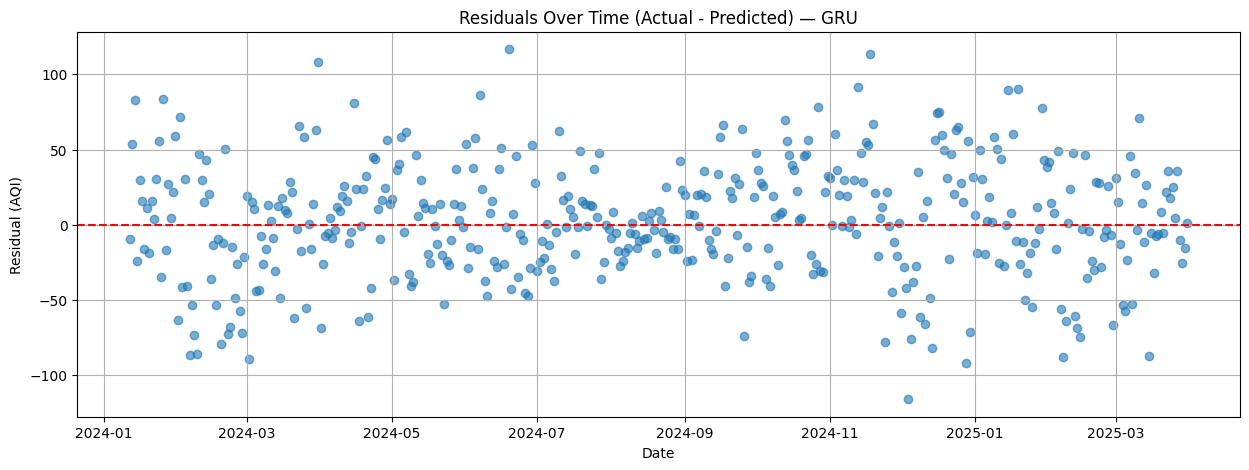

In [73]:
residuals = true_GRU - pred_GRU

plt.figure(figsize=(15, 5))
plt.scatter(dates_test, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time (Actual - Predicted) — GRU")
plt.xlabel("Date")
plt.ylabel("Residual (AQI)")
plt.grid(True)
plt.show()

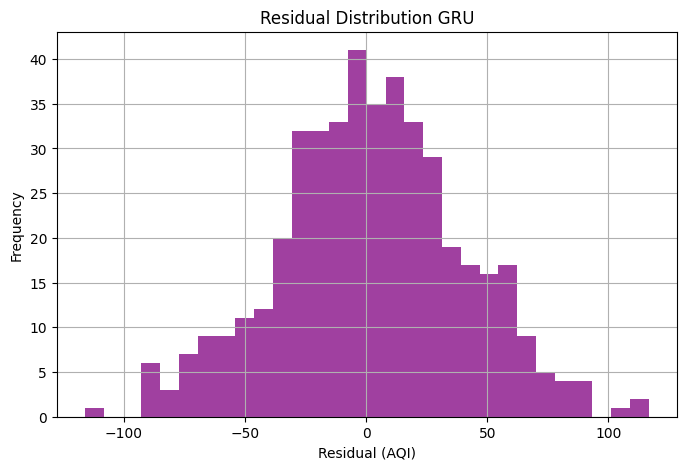

In [74]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color="purple", alpha=0.75)
plt.title("Residual Distribution GRU")
plt.xlabel("Residual (AQI)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [66]:
model_gru_2 = Sequential([
    GRU(128, return_sequences=True, activation='tanh', input_shape=(n_steps_gru, n_features)),
    Dropout(0.25),

    GRU(64, activation='tanh'),
    Dropout(0.20),

    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile using Huber loss (delta=1.0 default)
model_gru_2.compile(
    optimizer='adam',
    loss=Huber(delta=1.0)       # 👈 replaces MSE with Huber
)

model_gru_2.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 7, 128)         │        63,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,721 (401.25 KB)

 Trainable params: 102,721 (401.25 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history_gru_2 = model_gru_2.fit(
    train_gen_gru,
    validation_data=val_gen_gru,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0314 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0071 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━

In [68]:
rmse_GRU_2 , pred_GRU_2 , true_GRU_2 = evaluate_model(model_gru_2, "GRU2")


===== Evaluating: GRU2 =====
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE on Test Set: 40.72 AQI points
R² Score: 0.8329


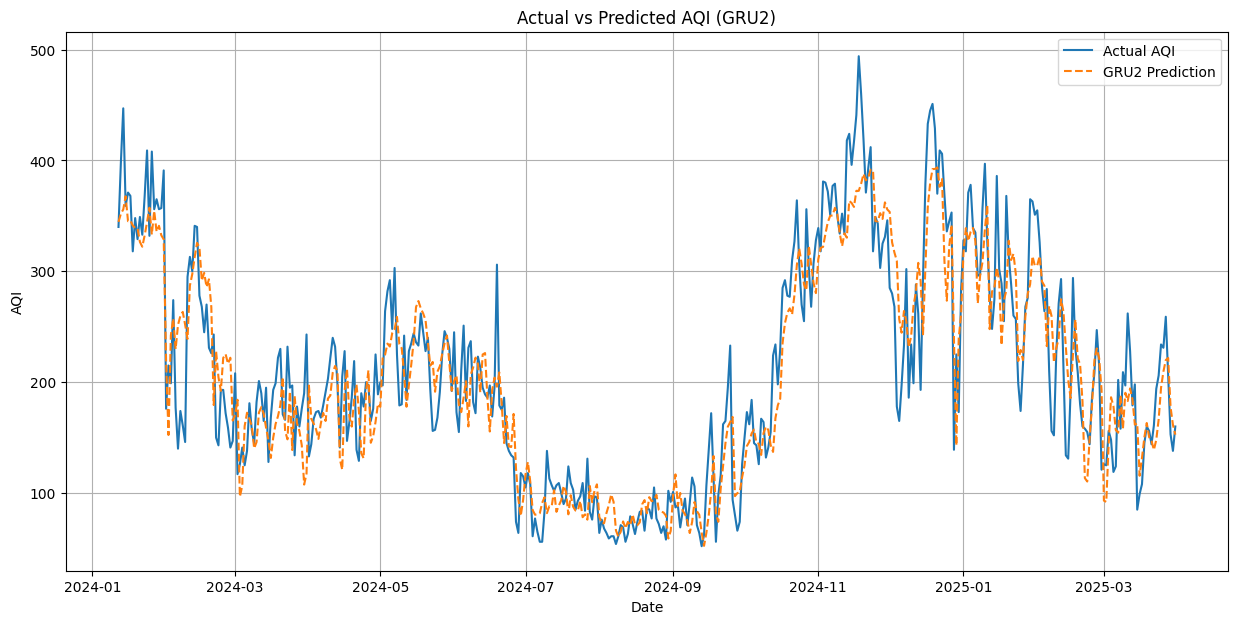

In [69]:
plt.figure(figsize=(15,7))
plt.plot(dates_test, true_GRU_2, label="Actual AQI")
plt.plot(dates_test, pred_GRU_2, label=f"GRU2 Prediction", linestyle='--')
plt.title(f"Actual vs Predicted AQI (GRU2)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()